In [1]:
# 📦 Стандартные библиотеки
import os
import json
import time
import random
import glob
from pathlib import Path

# 📊 Обработка и визуализация данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 🤖 Машинное обучение (sklearn)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ⏳ Прогресс-бар
from tqdm import tqdm

In [2]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

# ----------------------------
# Paths setup (UNIX style)
# ----------------------------

# 🔧 Вставь сюда свои актуальные пути:
# DATA_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input")
DATA_ROOT = Path("/kaggle/input")
# SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f")
SAVE_ROOT = Path("/kaggle/working/")
# CONFIG_PATH = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json")
CONFIG_PATH = Path("/kaggle/input/cnn_2e-04lr_64bs_ELU_16f.json")
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"

# ----------------------------
# Function to create a run-specific directory
# ----------------------------
def create_run_directory(
    run_name="cnn", lr=1e-3, batch_size=64, epochs=500,
    activation_fn=None, optimizer_name=None, base_dir=SAVE_ROOT
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"
    
    run_dir = base_dir / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir


🛠 Device: cuda


In [3]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
# ➤ Пользовательский Dataset
class WindGridDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ➤ Оценка
def evaluate_regression(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().reshape(-1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return {
        "MSE": mean_squared_error(y_true[mask], y_pred[mask]),
        "MAE": mean_absolute_error(y_true[mask], y_pred[mask]),
        "R2": r2_score(y_true[mask], y_pred[mask])
    }

In [5]:
# ➤ Основная функция
def train_cnn(
    lr,
    batch_size,
    epochs,
    input_channels,
    activation_fn,
    optimizer_name,
    loss_fn,
    filters,
    use_batchnorm,
    run_id,
    X_train, Y_train,
    X_val, Y_val,
    best_r2
    ):
    # ✅ Переводим данные в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
    Y_val   = torch.tensor(Y_val,   dtype=torch.float32).to(device)
    
    print("✅ Данные загружены в модель:")
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    
    # 🎯 Основной график распределения
    plt.figure(figsize=(10, 5))
    plt.hist(Y_train.cpu().flatten(), bins=50, alpha=0.6, label='Train Y')  # <-- добавлено .cpu()
    plt.hist(Y_val.cpu().flatten(), bins=50, alpha=0.6, label='Val Y')      # <-- добавлено .cpu()
    plt.xlabel("Target Value")
    plt.ylabel("Frequency")
    plt.title(f"🎯 Target Distribution — Train vs Val")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    model = WindPressureCNN(
        input_channels=input_channels,
        filters=filters,
        activation_fn=activation_fn,
        use_batchnorm=use_batchnorm
    ).to(device)

    # Функция потерь
    criterion = loss_fn()

    # Оптимизатор
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Датасеты и загрузчики
    train_loader = DataLoader(WindGridDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(WindGridDataset(X_val, Y_val), batch_size=batch_size)

    # Тренировка
    best_loss = float("inf")
    patience = 150
    counter = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Валидация каждые 100 эпох
        if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                epoch_metrics = evaluate_regression(Y_val, y_val_pred)
                print(f"📉 Epoch {epoch + 1} | Train Loss: {epoch_loss:.6f} | "
                      f"Val R2: {epoch_metrics['R2']:.4f} | "
                      f"MAE: {epoch_metrics['MAE']:.4f} | "
                      f"MSE: {epoch_metrics['MSE']:.6f}")

        # Early Stopping
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                val_loss += loss.item()

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping")
                break

    # Оценка на валидации (финал)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        metrics = evaluate_regression(Y_val, y_pred)
        print(f"\n📈 Final Validation Metrics: {metrics}")

    if metrics["R2"] > best_r2:
        # Обновляем лучшую метрику
        best_r2 = metrics["R2"]
        
        # Удаляем все старые .pth в SAVE_ROOT
        for f in glob.glob(os.path.join(SAVE_ROOT, "*.pth")):
            os.remove(f)

        # Создаём красивое имя для сохранения весов
        filters_str = "-".join(map(str, filters))
        MODEL_FILENAME = (
        f"best_"
        f"{run_id}_"
        f"{activation_fn.__name__}_"
        f"{optimizer_name}.pth"
        )

        MODEL_SAVE_PATH = os.path.join(SAVE_ROOT, MODEL_FILENAME)

        # Сохраняем новые веса
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Сохранена новая лучшая модель: {MODEL_SAVE_PATH} (R² = {best_r2:.4f})")

    return model, metrics, best_r2
   



seeds: [492136, 106420, 215030, 905522, 859969, 844071, 578254, 154423, 226348, 333787]

🌱 Starting training with seed 492136
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


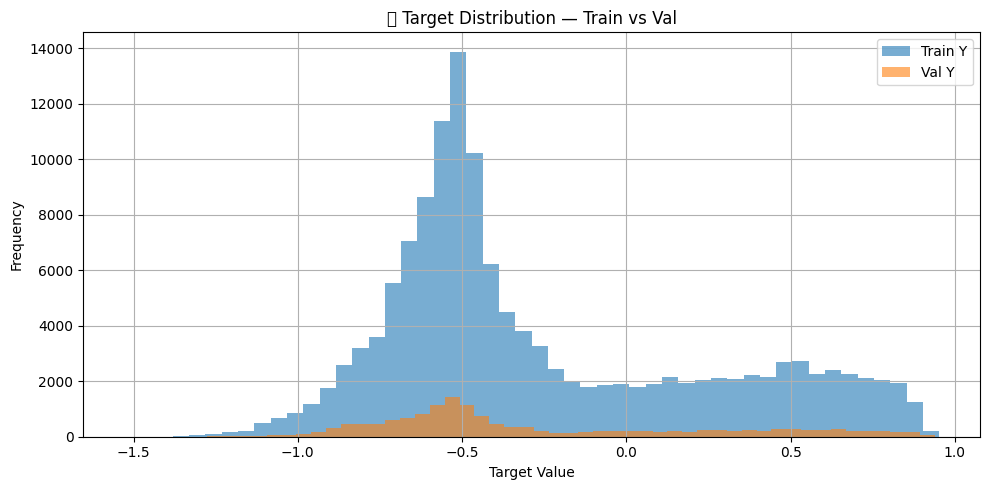

Epochs:   0%|          | 2/3000 [00:01<35:49,  1.39it/s]  

📉 Epoch 1 | Train Loss: 1.959455 | Val R2: -0.3948 | MAE: 0.5475 | MSE: 0.359465


Epochs:   3%|▎         | 101/3000 [00:18<08:15,  5.85it/s]

📉 Epoch 100 | Train Loss: 0.181743 | Val R2: 0.9510 | MAE: 0.0810 | MSE: 0.012634


Epochs:   7%|▋         | 201/3000 [00:35<08:12,  5.69it/s]

📉 Epoch 200 | Train Loss: 0.096181 | Val R2: 0.9637 | MAE: 0.0637 | MSE: 0.009361


Epochs:  10%|█         | 301/3000 [00:53<08:04,  5.58it/s]

📉 Epoch 300 | Train Loss: 0.066369 | Val R2: 0.9756 | MAE: 0.0531 | MSE: 0.006282


Epochs:  13%|█▎        | 401/3000 [01:11<07:51,  5.51it/s]

📉 Epoch 400 | Train Loss: 0.089934 | Val R2: 0.9710 | MAE: 0.0566 | MSE: 0.007465


Epochs:  17%|█▋        | 501/3000 [01:29<07:40,  5.42it/s]

📉 Epoch 500 | Train Loss: 0.062638 | Val R2: 0.9775 | MAE: 0.0502 | MSE: 0.005792


Epochs:  20%|██        | 600/3000 [01:47<07:22,  5.43it/s]

📉 Epoch 600 | Train Loss: 0.056596 | Val R2: 0.9804 | MAE: 0.0455 | MSE: 0.005048


Epochs:  23%|██▎       | 701/3000 [02:05<06:58,  5.50it/s]

📉 Epoch 700 | Train Loss: 0.055635 | Val R2: 0.9691 | MAE: 0.0548 | MSE: 0.007968


Epochs:  27%|██▋       | 801/3000 [02:23<06:40,  5.49it/s]

📉 Epoch 800 | Train Loss: 0.038241 | Val R2: 0.9830 | MAE: 0.0417 | MSE: 0.004391


Epochs:  30%|███       | 901/3000 [02:42<06:20,  5.52it/s]

📉 Epoch 900 | Train Loss: 0.066118 | Val R2: 0.9733 | MAE: 0.0549 | MSE: 0.006882


Epochs:  32%|███▏      | 949/3000 [02:51<06:09,  5.55it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0051350133, 'MAE': 0.046532467, 'R2': 0.9800749395894358}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed492136_ELU_Adam.pth (R² = 0.9801)
✅ Done: input_seed492136
📊 Metrics: R²=0.9801 | MSE=0.005135 | MAE=0.046532

🌱 Starting training with seed 106420
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


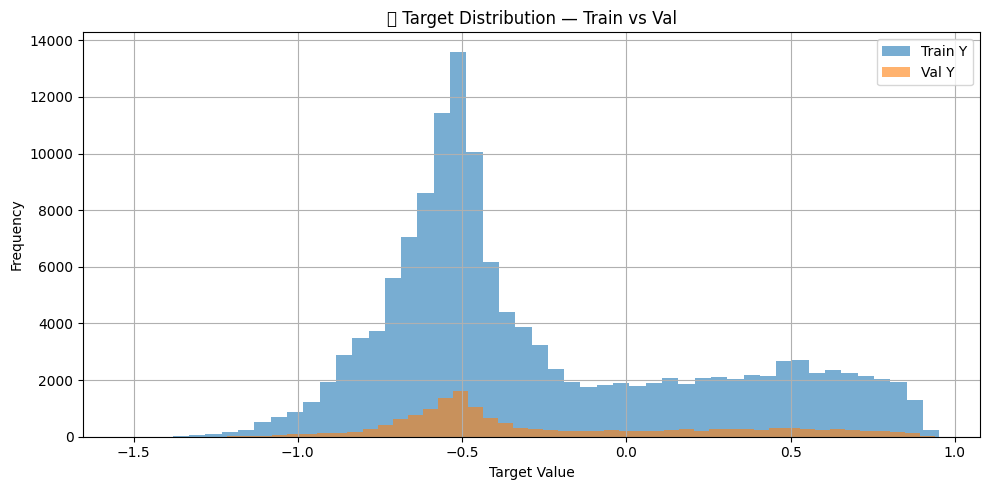

Epochs:   0%|          | 2/3000 [00:00<10:35,  4.72it/s]

📉 Epoch 1 | Train Loss: 1.854312 | Val R2: -0.0480 | MAE: 0.4497 | MSE: 0.249302


Epochs:   3%|▎         | 101/3000 [00:18<08:59,  5.38it/s]

📉 Epoch 100 | Train Loss: 0.170107 | Val R2: 0.9472 | MAE: 0.0773 | MSE: 0.012567


Epochs:   7%|▋         | 201/3000 [00:36<08:31,  5.47it/s]

📉 Epoch 200 | Train Loss: 0.120112 | Val R2: 0.9670 | MAE: 0.0605 | MSE: 0.007857


Epochs:  10%|█         | 301/3000 [00:54<08:11,  5.49it/s]

📉 Epoch 300 | Train Loss: 0.111411 | Val R2: 0.9649 | MAE: 0.0586 | MSE: 0.008359


Epochs:  13%|█▎        | 401/3000 [01:13<07:59,  5.42it/s]

📉 Epoch 400 | Train Loss: 0.076152 | Val R2: 0.9725 | MAE: 0.0549 | MSE: 0.006534


Epochs:  17%|█▋        | 501/3000 [01:31<07:33,  5.51it/s]

📉 Epoch 500 | Train Loss: 0.068293 | Val R2: 0.9715 | MAE: 0.0560 | MSE: 0.006780


Epochs:  20%|██        | 601/3000 [01:49<07:22,  5.42it/s]

📉 Epoch 600 | Train Loss: 0.065030 | Val R2: 0.9743 | MAE: 0.0503 | MSE: 0.006106


Epochs:  23%|██▎       | 701/3000 [02:07<07:00,  5.47it/s]

📉 Epoch 700 | Train Loss: 0.080367 | Val R2: 0.9709 | MAE: 0.0548 | MSE: 0.006931


Epochs:  27%|██▋       | 801/3000 [02:25<06:43,  5.46it/s]

📉 Epoch 800 | Train Loss: 0.059534 | Val R2: 0.9756 | MAE: 0.0501 | MSE: 0.005809


Epochs:  30%|███       | 901/3000 [02:43<06:21,  5.50it/s]

📉 Epoch 900 | Train Loss: 0.085567 | Val R2: 0.9734 | MAE: 0.0544 | MSE: 0.006331


Epochs:  33%|███▎      | 1001/3000 [03:02<06:04,  5.48it/s]

📉 Epoch 1000 | Train Loss: 0.079908 | Val R2: 0.9738 | MAE: 0.0489 | MSE: 0.006239


Epochs:  35%|███▌      | 1062/3000 [03:13<05:52,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0049210154, 'MAE': 0.044192042, 'R2': 0.9793141009049577}
✅ Done: input_seed106420
📊 Metrics: R²=0.9793 | MSE=0.004921 | MAE=0.044192

🌱 Starting training with seed 215030
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


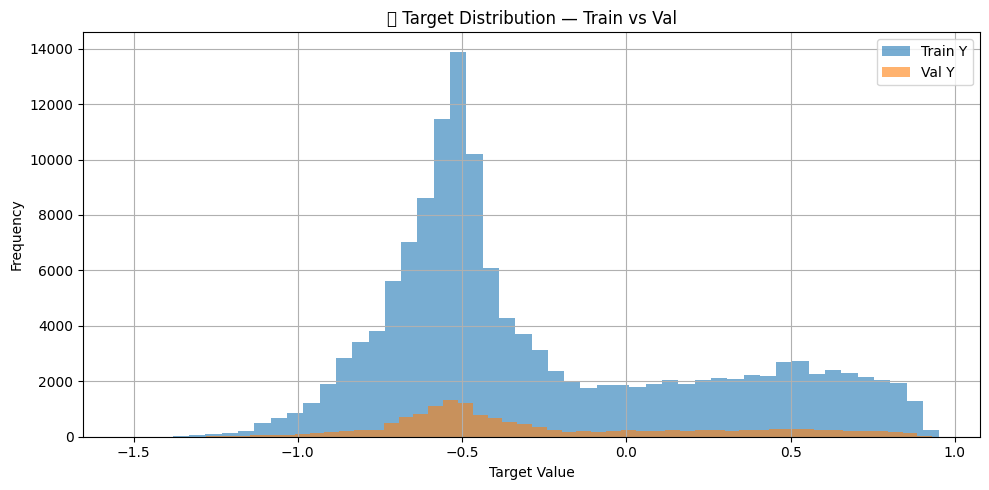

Epochs:   0%|          | 2/3000 [00:00<10:42,  4.67it/s]

📉 Epoch 1 | Train Loss: 2.055365 | Val R2: -0.1101 | MAE: 0.4622 | MSE: 0.264657


Epochs:   3%|▎         | 101/3000 [00:18<08:54,  5.42it/s]

📉 Epoch 100 | Train Loss: 0.141051 | Val R2: 0.9387 | MAE: 0.0868 | MSE: 0.014606


Epochs:   7%|▋         | 201/3000 [00:36<08:34,  5.44it/s]

📉 Epoch 200 | Train Loss: 0.103238 | Val R2: 0.9549 | MAE: 0.0717 | MSE: 0.010757


Epochs:  10%|█         | 301/3000 [00:54<08:12,  5.48it/s]

📉 Epoch 300 | Train Loss: 0.070977 | Val R2: 0.9725 | MAE: 0.0547 | MSE: 0.006546


Epochs:  13%|█▎        | 401/3000 [01:13<07:54,  5.48it/s]

📉 Epoch 400 | Train Loss: 0.080533 | Val R2: 0.9693 | MAE: 0.0564 | MSE: 0.007330


Epochs:  17%|█▋        | 501/3000 [01:31<07:39,  5.44it/s]

📉 Epoch 500 | Train Loss: 0.051409 | Val R2: 0.9753 | MAE: 0.0508 | MSE: 0.005882


Epochs:  20%|██        | 601/3000 [01:49<07:18,  5.47it/s]

📉 Epoch 600 | Train Loss: 0.047342 | Val R2: 0.9703 | MAE: 0.0559 | MSE: 0.007086


Epochs:  23%|██▎       | 701/3000 [02:07<07:07,  5.37it/s]

📉 Epoch 700 | Train Loss: 0.045857 | Val R2: 0.9746 | MAE: 0.0489 | MSE: 0.006057


Epochs:  27%|██▋       | 801/3000 [02:25<06:43,  5.45it/s]

📉 Epoch 800 | Train Loss: 0.039201 | Val R2: 0.9789 | MAE: 0.0450 | MSE: 0.005026


Epochs:  29%|██▉       | 884/3000 [02:41<06:25,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0073924316, 'MAE': 0.0581543, 'R2': 0.9689913233521813}
✅ Done: input_seed215030
📊 Metrics: R²=0.9690 | MSE=0.007392 | MAE=0.058154

🌱 Starting training with seed 905522
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


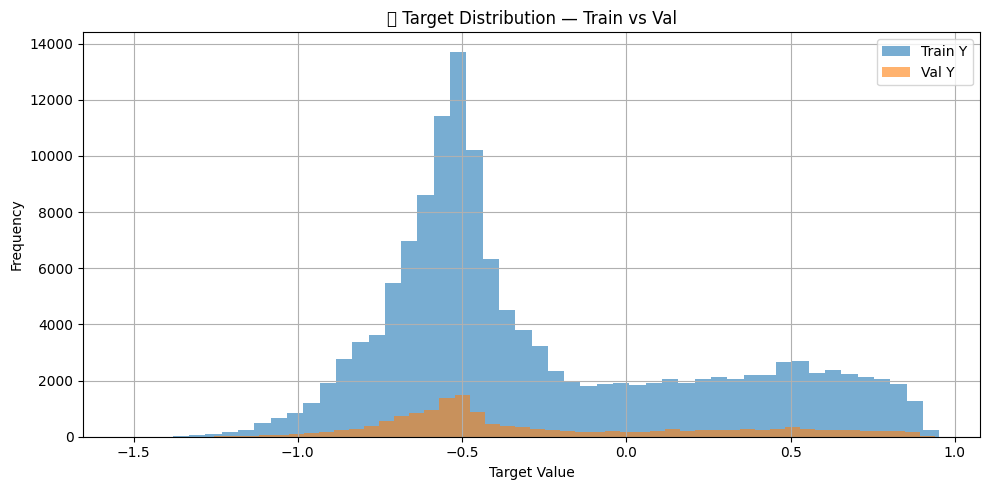

Epochs:   0%|          | 2/3000 [00:00<10:42,  4.67it/s]

📉 Epoch 1 | Train Loss: 1.851326 | Val R2: -0.0747 | MAE: 0.4739 | MSE: 0.273584


Epochs:   3%|▎         | 101/3000 [00:18<08:48,  5.48it/s]

📉 Epoch 100 | Train Loss: 0.151615 | Val R2: 0.9400 | MAE: 0.0840 | MSE: 0.015277


Epochs:   7%|▋         | 201/3000 [00:36<08:31,  5.48it/s]

📉 Epoch 200 | Train Loss: 0.111163 | Val R2: 0.9689 | MAE: 0.0624 | MSE: 0.007921


Epochs:  10%|█         | 301/3000 [00:54<08:20,  5.39it/s]

📉 Epoch 300 | Train Loss: 0.101748 | Val R2: 0.9717 | MAE: 0.0597 | MSE: 0.007200


Epochs:  13%|█▎        | 401/3000 [01:13<07:58,  5.43it/s]

📉 Epoch 400 | Train Loss: 0.064827 | Val R2: 0.9764 | MAE: 0.0502 | MSE: 0.006010


Epochs:  17%|█▋        | 501/3000 [01:31<07:38,  5.45it/s]

📉 Epoch 500 | Train Loss: 0.147642 | Val R2: 0.9654 | MAE: 0.0649 | MSE: 0.008804


Epochs:  20%|██        | 601/3000 [01:49<07:18,  5.47it/s]

📉 Epoch 600 | Train Loss: 0.074068 | Val R2: 0.9796 | MAE: 0.0480 | MSE: 0.005196


Epochs:  22%|██▏       | 670/3000 [02:02<07:04,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.005367321, 'MAE': 0.047759715, 'R2': 0.9789159571277488}
✅ Done: input_seed905522
📊 Metrics: R²=0.9789 | MSE=0.005367 | MAE=0.047760

🌱 Starting training with seed 859969
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


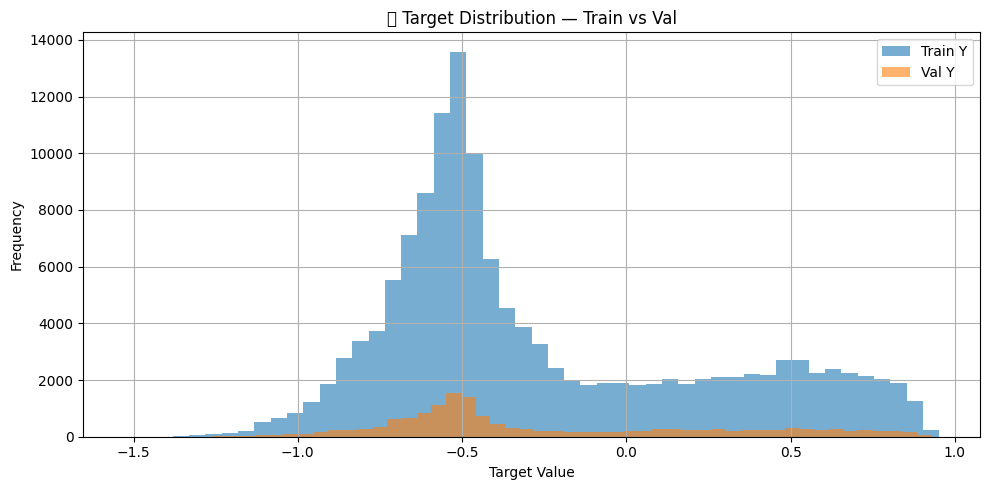

Epochs:   0%|          | 2/3000 [00:00<10:24,  4.80it/s]

📉 Epoch 1 | Train Loss: 1.941521 | Val R2: -0.1245 | MAE: 0.4841 | MSE: 0.282161


Epochs:   3%|▎         | 101/3000 [00:18<08:54,  5.43it/s]

📉 Epoch 100 | Train Loss: 0.180615 | Val R2: 0.9205 | MAE: 0.0931 | MSE: 0.019956


Epochs:   7%|▋         | 201/3000 [00:36<08:36,  5.42it/s]

📉 Epoch 200 | Train Loss: 0.109494 | Val R2: 0.9622 | MAE: 0.0656 | MSE: 0.009473


Epochs:  10%|█         | 301/3000 [00:54<08:12,  5.48it/s]

📉 Epoch 300 | Train Loss: 0.118358 | Val R2: 0.9433 | MAE: 0.0822 | MSE: 0.014239


Epochs:  13%|█▎        | 401/3000 [01:13<07:51,  5.52it/s]

📉 Epoch 400 | Train Loss: 0.062294 | Val R2: 0.9729 | MAE: 0.0545 | MSE: 0.006791


Epochs:  17%|█▋        | 501/3000 [01:31<07:38,  5.45it/s]

📉 Epoch 500 | Train Loss: 0.050084 | Val R2: 0.9783 | MAE: 0.0470 | MSE: 0.005438


Epochs:  20%|██        | 601/3000 [01:49<07:18,  5.48it/s]

📉 Epoch 600 | Train Loss: 0.052825 | Val R2: 0.9713 | MAE: 0.0554 | MSE: 0.007205


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.059902 | Val R2: 0.9721 | MAE: 0.0561 | MSE: 0.007005


Epochs:  27%|██▋       | 801/3000 [02:25<06:44,  5.44it/s]

📉 Epoch 800 | Train Loss: 0.046715 | Val R2: 0.9786 | MAE: 0.0469 | MSE: 0.005377


Epochs:  30%|███       | 901/3000 [02:43<06:21,  5.50it/s]

📉 Epoch 900 | Train Loss: 0.056633 | Val R2: 0.9691 | MAE: 0.0584 | MSE: 0.007761


Epochs:  32%|███▏      | 955/3000 [02:53<06:12,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0055948524, 'MAE': 0.04657595, 'R2': 0.9777020197474705}
✅ Done: input_seed859969
📊 Metrics: R²=0.9777 | MSE=0.005595 | MAE=0.046576

🌱 Starting training with seed 844071
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


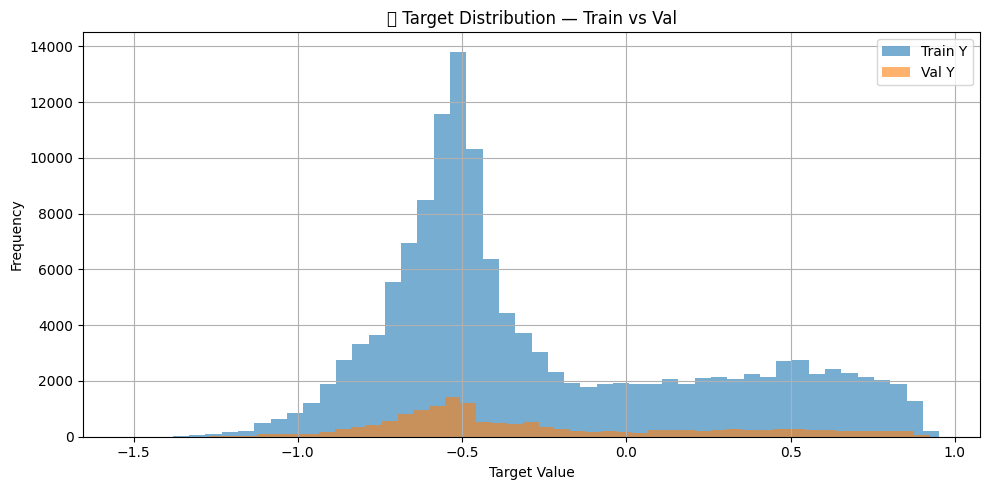

Epochs:   0%|          | 2/3000 [00:00<10:25,  4.79it/s]

📉 Epoch 1 | Train Loss: 1.977996 | Val R2: -0.2722 | MAE: 0.5108 | MSE: 0.315189


Epochs:   3%|▎         | 101/3000 [00:18<08:52,  5.45it/s]

📉 Epoch 100 | Train Loss: 0.157545 | Val R2: 0.9534 | MAE: 0.0741 | MSE: 0.011545


Epochs:   7%|▋         | 201/3000 [00:36<08:35,  5.43it/s]

📉 Epoch 200 | Train Loss: 0.143208 | Val R2: 0.9512 | MAE: 0.0798 | MSE: 0.012085


Epochs:  10%|█         | 301/3000 [00:54<08:22,  5.37it/s]

📉 Epoch 300 | Train Loss: 0.088173 | Val R2: 0.9617 | MAE: 0.0694 | MSE: 0.009487


Epochs:  13%|█▎        | 401/3000 [01:13<07:56,  5.46it/s]

📉 Epoch 400 | Train Loss: 0.081619 | Val R2: 0.9714 | MAE: 0.0549 | MSE: 0.007075


Epochs:  17%|█▋        | 501/3000 [01:31<07:38,  5.45it/s]

📉 Epoch 500 | Train Loss: 0.082441 | Val R2: 0.9616 | MAE: 0.0683 | MSE: 0.009516


Epochs:  20%|██        | 601/3000 [01:49<07:19,  5.46it/s]

📉 Epoch 600 | Train Loss: 0.054050 | Val R2: 0.9721 | MAE: 0.0547 | MSE: 0.006916


Epochs:  20%|██        | 608/3000 [01:50<07:16,  5.48it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0067200637, 'MAE': 0.053918656, 'R2': 0.9728760636045924}
✅ Done: input_seed844071
📊 Metrics: R²=0.9729 | MSE=0.006720 | MAE=0.053919

🌱 Starting training with seed 578254
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


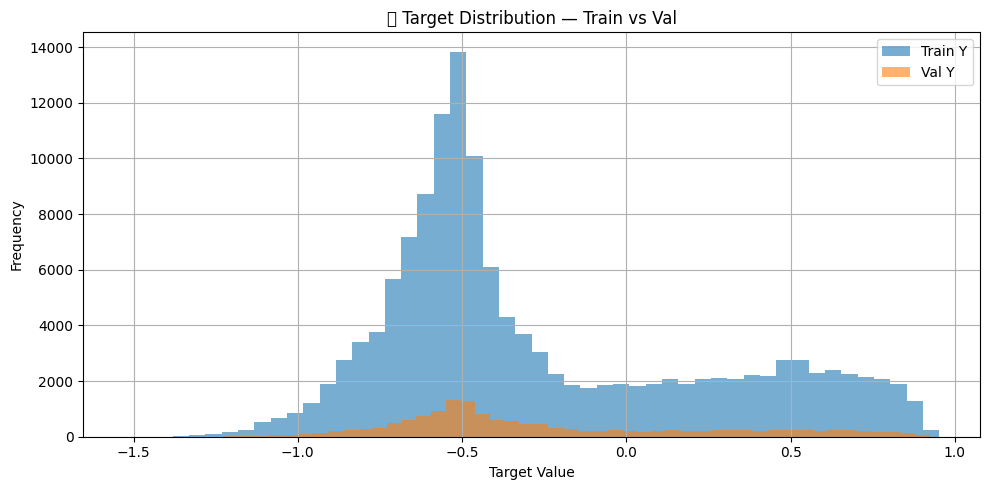

Epochs:   0%|          | 2/3000 [00:00<10:28,  4.77it/s]

📉 Epoch 1 | Train Loss: 1.811752 | Val R2: -0.4661 | MAE: 0.5243 | MSE: 0.335359


Epochs:   3%|▎         | 101/3000 [00:18<08:51,  5.45it/s]

📉 Epoch 100 | Train Loss: 0.137583 | Val R2: 0.9288 | MAE: 0.0855 | MSE: 0.016288


Epochs:   7%|▋         | 201/3000 [00:36<08:39,  5.39it/s]

📉 Epoch 200 | Train Loss: 0.105808 | Val R2: 0.9531 | MAE: 0.0741 | MSE: 0.010731


Epochs:  10%|█         | 301/3000 [00:54<08:19,  5.40it/s]

📉 Epoch 300 | Train Loss: 0.117038 | Val R2: 0.9579 | MAE: 0.0685 | MSE: 0.009621


Epochs:  13%|█▎        | 401/3000 [01:13<07:57,  5.45it/s]

📉 Epoch 400 | Train Loss: 0.068223 | Val R2: 0.9685 | MAE: 0.0585 | MSE: 0.007210


Epochs:  17%|█▋        | 501/3000 [01:31<07:41,  5.42it/s]

📉 Epoch 500 | Train Loss: 0.088004 | Val R2: 0.9645 | MAE: 0.0606 | MSE: 0.008109


Epochs:  18%|█▊        | 525/3000 [01:35<07:31,  5.48it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0068380916, 'MAE': 0.056378003, 'R2': 0.9701051192607636}
✅ Done: input_seed578254
📊 Metrics: R²=0.9701 | MSE=0.006838 | MAE=0.056378

🌱 Starting training with seed 154423
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


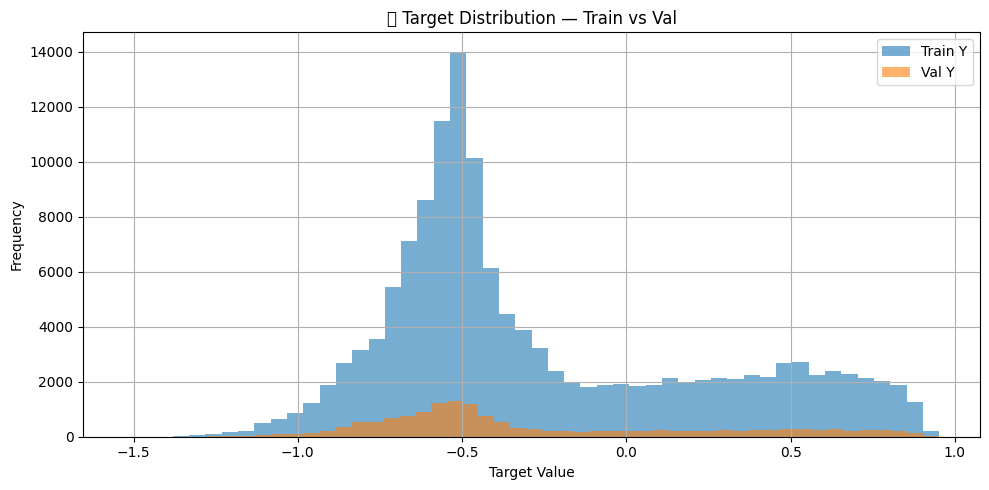

Epochs:   0%|          | 2/3000 [00:00<10:18,  4.84it/s]

📉 Epoch 1 | Train Loss: 1.867593 | Val R2: -0.1103 | MAE: 0.4855 | MSE: 0.286967


Epochs:   3%|▎         | 101/3000 [00:18<08:47,  5.50it/s]

📉 Epoch 100 | Train Loss: 0.163551 | Val R2: 0.9460 | MAE: 0.0815 | MSE: 0.013944


Epochs:   7%|▋         | 201/3000 [00:36<08:31,  5.47it/s]

📉 Epoch 200 | Train Loss: 0.095806 | Val R2: 0.9651 | MAE: 0.0637 | MSE: 0.009032


Epochs:  10%|█         | 301/3000 [00:54<08:11,  5.50it/s]

📉 Epoch 300 | Train Loss: 0.125818 | Val R2: 0.9689 | MAE: 0.0601 | MSE: 0.008037


Epochs:  13%|█▎        | 401/3000 [01:12<07:55,  5.47it/s]

📉 Epoch 400 | Train Loss: 0.094320 | Val R2: 0.9672 | MAE: 0.0602 | MSE: 0.008489


Epochs:  17%|█▋        | 501/3000 [01:31<07:32,  5.52it/s]

📉 Epoch 500 | Train Loss: 0.069041 | Val R2: 0.9706 | MAE: 0.0569 | MSE: 0.007590


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.113305 | Val R2: 0.9627 | MAE: 0.0643 | MSE: 0.009631


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.083783 | Val R2: 0.9653 | MAE: 0.0616 | MSE: 0.008964


Epochs:  27%|██▋       | 801/3000 [02:25<06:39,  5.50it/s]

📉 Epoch 800 | Train Loss: 0.068229 | Val R2: 0.9532 | MAE: 0.0716 | MSE: 0.012097


Epochs:  30%|███       | 901/3000 [02:43<06:25,  5.45it/s]

📉 Epoch 900 | Train Loss: 0.059443 | Val R2: 0.9114 | MAE: 0.0855 | MSE: 0.022900


Epochs:  33%|███▎      | 1001/3000 [03:02<06:05,  5.46it/s]

📉 Epoch 1000 | Train Loss: 0.072858 | Val R2: 0.9644 | MAE: 0.0635 | MSE: 0.009203


Epochs:  34%|███▍      | 1016/3000 [03:04<06:01,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0052425424, 'MAE': 0.045552865, 'R2': 0.9797154972566092}
✅ Done: input_seed154423
📊 Metrics: R²=0.9797 | MSE=0.005243 | MAE=0.045553

🌱 Starting training with seed 226348
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


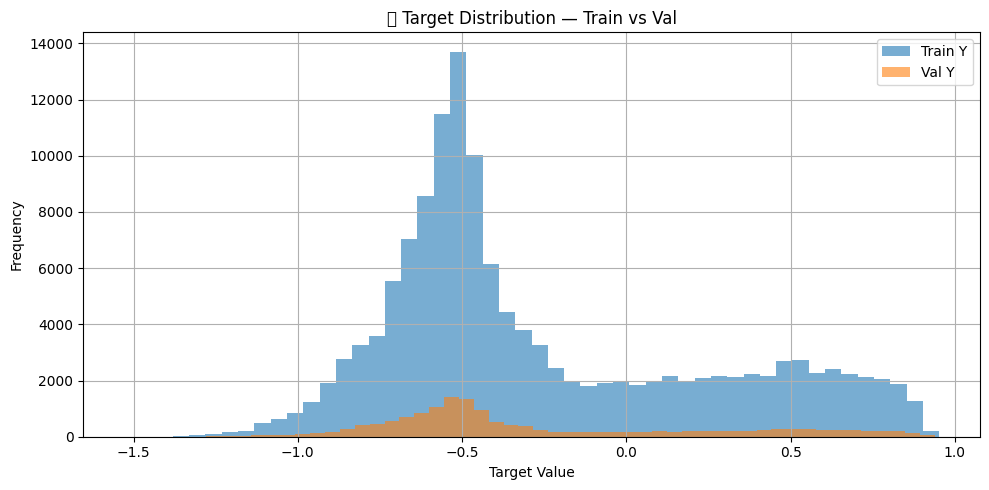

Epochs:   0%|          | 2/3000 [00:00<10:32,  4.74it/s]

📉 Epoch 1 | Train Loss: 1.797214 | Val R2: -0.2318 | MAE: 0.5134 | MSE: 0.312393


Epochs:   3%|▎         | 101/3000 [00:18<08:50,  5.46it/s]

📉 Epoch 100 | Train Loss: 0.257053 | Val R2: 0.9472 | MAE: 0.0827 | MSE: 0.013402


Epochs:   7%|▋         | 201/3000 [00:36<08:35,  5.43it/s]

📉 Epoch 200 | Train Loss: 0.117741 | Val R2: 0.9612 | MAE: 0.0666 | MSE: 0.009830


Epochs:  10%|█         | 301/3000 [00:54<08:14,  5.45it/s]

📉 Epoch 300 | Train Loss: 0.090700 | Val R2: 0.9719 | MAE: 0.0582 | MSE: 0.007117


Epochs:  13%|█▎        | 401/3000 [01:13<07:56,  5.46it/s]

📉 Epoch 400 | Train Loss: 0.078136 | Val R2: 0.9667 | MAE: 0.0608 | MSE: 0.008447


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.50it/s]

📉 Epoch 500 | Train Loss: 0.126468 | Val R2: 0.9453 | MAE: 0.0777 | MSE: 0.013871


Epochs:  20%|██        | 601/3000 [01:49<07:19,  5.46it/s]

📉 Epoch 600 | Train Loss: 0.054588 | Val R2: 0.9788 | MAE: 0.0474 | MSE: 0.005374


Epochs:  23%|██▎       | 701/3000 [02:07<07:02,  5.44it/s]

📉 Epoch 700 | Train Loss: 0.071443 | Val R2: 0.9723 | MAE: 0.0547 | MSE: 0.007025


Epochs:  25%|██▍       | 749/3000 [02:16<06:50,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0059993346, 'MAE': 0.049484264, 'R2': 0.976344041019708}
✅ Done: input_seed226348
📊 Metrics: R²=0.9763 | MSE=0.005999 | MAE=0.049484

🌱 Starting training with seed 333787
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


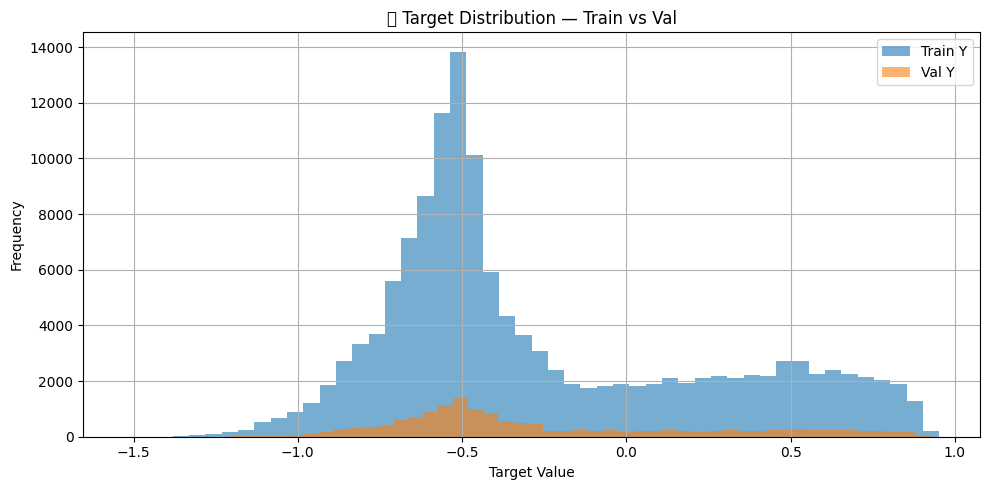

Epochs:   0%|          | 2/3000 [00:00<10:35,  4.71it/s]

📉 Epoch 1 | Train Loss: 1.996186 | Val R2: -0.2864 | MAE: 0.5016 | MSE: 0.303332


Epochs:   3%|▎         | 101/3000 [00:18<08:53,  5.43it/s]

📉 Epoch 100 | Train Loss: 0.144012 | Val R2: 0.9498 | MAE: 0.0763 | MSE: 0.011841


Epochs:   7%|▋         | 201/3000 [00:36<08:35,  5.43it/s]

📉 Epoch 200 | Train Loss: 0.130108 | Val R2: 0.9417 | MAE: 0.0800 | MSE: 0.013743


Epochs:  10%|█         | 301/3000 [00:54<08:14,  5.46it/s]

📉 Epoch 300 | Train Loss: 0.089201 | Val R2: 0.9578 | MAE: 0.0653 | MSE: 0.009939


Epochs:  13%|█▎        | 401/3000 [01:13<07:54,  5.48it/s]

📉 Epoch 400 | Train Loss: 0.076993 | Val R2: 0.9687 | MAE: 0.0571 | MSE: 0.007371


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.50it/s]

📉 Epoch 500 | Train Loss: 0.110034 | Val R2: 0.9470 | MAE: 0.0733 | MSE: 0.012497


Epochs:  20%|██        | 601/3000 [01:49<07:20,  5.45it/s]

📉 Epoch 600 | Train Loss: 0.064849 | Val R2: 0.9734 | MAE: 0.0536 | MSE: 0.006271


Epochs:  23%|██▎       | 701/3000 [02:07<07:01,  5.46it/s]

📉 Epoch 700 | Train Loss: 0.056837 | Val R2: 0.9699 | MAE: 0.0593 | MSE: 0.007090


Epochs:  27%|██▋       | 801/3000 [02:25<06:41,  5.48it/s]

📉 Epoch 800 | Train Loss: 0.082056 | Val R2: 0.9719 | MAE: 0.0539 | MSE: 0.006623


Epochs:  30%|███       | 901/3000 [02:43<06:24,  5.45it/s]

📉 Epoch 900 | Train Loss: 0.040525 | Val R2: 0.9736 | MAE: 0.0516 | MSE: 0.006215


Epochs:  33%|███▎      | 1001/3000 [03:02<06:10,  5.40it/s]

📉 Epoch 1000 | Train Loss: 0.089867 | Val R2: 0.9679 | MAE: 0.0560 | MSE: 0.007571


Epochs:  37%|███▋      | 1101/3000 [03:20<05:46,  5.47it/s]

📉 Epoch 1100 | Train Loss: 0.058134 | Val R2: 0.9711 | MAE: 0.0543 | MSE: 0.006805


Epochs:  40%|████      | 1201/3000 [03:38<05:29,  5.45it/s]

📉 Epoch 1200 | Train Loss: 0.040113 | Val R2: 0.9772 | MAE: 0.0463 | MSE: 0.005376


Epochs:  43%|████▎     | 1298/3000 [03:56<05:09,  5.49it/s]

⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.005272269, 'MAE': 0.046476692, 'R2': 0.9776403897351473}
✅ Done: input_seed333787
📊 Metrics: R²=0.9776 | MSE=0.005272 | MAE=0.046477

🏆 Лучший запуск:
🆔 Run ID: input_seed492136
📈 R²: 0.9801
📉 MAE: 0.0465
📉 MSE: 0.005135


In [6]:
all_results = []

# === Установка сидов
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Загрузка данных и конфига
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)


X_all = np.load(DATA_ROOT / "X_cnn.npy")
Y_all = np.load(DATA_ROOT / "Y_cnn.npy")

# === Цикл по сидом
NUM_RUNS = 10
random.seed(int(time.time()))  # или просто random.seed() для более случайной генерации
seeds = random.sample(range(1_000_000), NUM_RUNS)  # 10 уникальных случайных seed
base_run_id = CONFIG_PATH.parent.name
print('seeds:', seeds)

best_r2 = -np.inf

for seed in seeds:
    print(f"\n🌱 Starting training with seed {seed}")
    set_seed(seed)

    # 💡 Разбиение train/val с текущим сидом
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_all, Y_all, test_size=0.1, random_state=seed
    )

    # 🔁 Создание новой копии конфига
    config_run = config.copy()
    run_id = f"{base_run_id}_seed{seed}"
    config_run["seed"] = seed
    config_run["run_id"] = run_id

    model, metrics, best_r2 = train_cnn(
        lr=config_run["lr"],
        batch_size=config_run["batch_size"],
        epochs=config_run["epochs"],
        input_channels=config_run["input_channels"],
        activation_fn=getattr(torch.nn, config_run["activation_fn"]),
        optimizer_name=config_run["optimizer"],
        loss_fn=getattr(torch.nn, config_run["loss_fn"]),
        filters=config_run["filters"],
        use_batchnorm=config_run["batchnorm"],
        run_id=run_id,
        X_train=X_train,
        Y_train=Y_train,
        X_val=X_val,
        Y_val=Y_val,
        best_r2 = best_r2
    )

    all_results.append({
        "run_id": run_id,
        "seed": seed,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    print(f"✅ Done: {run_id}")
    print(f"📊 Metrics: R²={metrics['R2']:.4f} | MSE={metrics['MSE']:.6f} | MAE={metrics['MAE']:.6f}")

    # === Логирование в CSV
    log_header = "run_id,seed,lr,batch_size,activation_fn,optimizer,filters,R2,MAE,MSE\n"

    log_line = (
        f"{run_id},{seed},{config_run['lr']:.0e},{config_run['batch_size']},"
        f"{config_run['activation_fn']},{config_run['optimizer']},"
        f"\"{config_run['filters']}\",{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n"
    )

    # Создаём файл, если его ещё нет
    write_header = not os.path.exists(LOG_CSV_PATH)

    with open(LOG_CSV_PATH, "a") as f:
        if write_header:
            f.write(log_header)
        f.write(log_line)

# Найдём лучший результат
best_result = max(all_results, key=lambda x: x["R2"])

# Выводим
print("\n🏆 Лучший запуск:")
print(f"🆔 Run ID: {best_result['run_id']}")
print(f"📈 R²: {best_result['R2']:.4f}")
print(f"📉 MAE: {best_result['MAE']:.4f}")
print(f"📉 MSE: {best_result['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_19/2889097417.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2889097417.py:56: UserWarning: Glyph 127919 (\N{DIRE

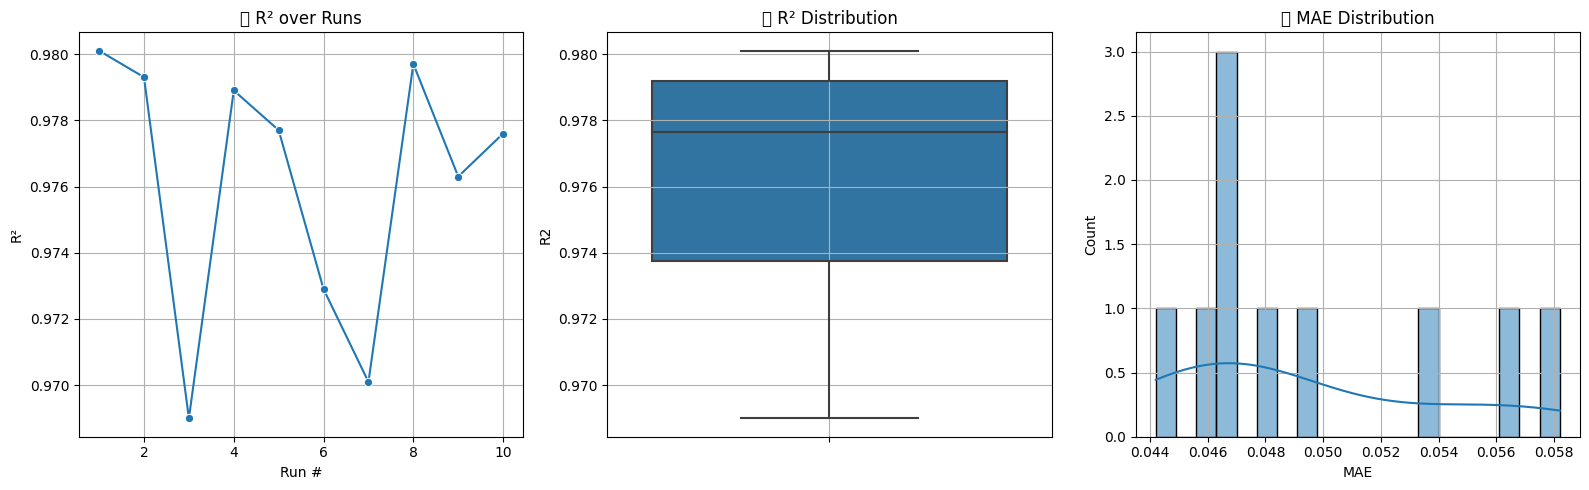

✅ Stability analysis complete:
{
    "R2_mean": 0.9762,
    "R2_std": 0.0041,
    "MAE_mean": 0.0495,
    "MAE_std": 0.0049,
    "MSE_mean": 0.005848,
    "MSE_std": 0.00085,
    "runs": 10
}
📁 Saved metrics: /kaggle/working/stability_working.json
🖼️  Saved plot: /kaggle/working/stability_plot_working.png


In [7]:
# 📁 src/tuning/analyze_stability.py

# 📌 Пути (адаптируй под свой путь к лог-файлу)

LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"
ARCH_LABEL = SAVE_ROOT.name  # используем имя папки как ярлык модели

# 📥 Загрузка результатов
df = pd.read_csv(LOG_CSV_PATH)

# ➕ Добавим колонку run по индексу
df["run"] = range(1, len(df) + 1)

# 📊 Подсчёт статистик стабильности
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Сохраняем метрики
stability_path = SAVE_ROOT / f"stability_{ARCH_LABEL}.json"
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Визуализация
plt.figure(figsize=(16, 5))

# ➤ R² по прогонам
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("📈 R² over Runs")
plt.xlabel("Run #")
plt.ylabel("R²")
plt.grid(True)

# ➤ Boxplot R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("🎯 R² Distribution")
plt.grid(True)

# ➤ Гистограмма MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("📉 MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Сохраняем график
fig_path = SAVE_ROOT / f"stability_plot_{ARCH_LABEL}.png"
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Вывод
print("✅ Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


In [ ]:
# ➤ Класс CNN-модели (предполагаем, что он уже определён выше)
# class WindPressureCNN(nn.Module): ...

# 📍 Укажи путь к конфигу и весам
CONFIG_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json"
MODEL_SAVE_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/best_input_seed882593_ELU_Adam.pth"

# ➤ Загружаем конфиг
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# ➤ Преобразуем имя функции активации в класс
activation_map = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "SELU": nn.SELU,
    "GELU": nn.GELU
}


activation_fn = activation_map[config["activation_fn"]]

# ➤ Воссоздаём модель
model = WindPressureCNN(
    input_channels=config["input_channels"],
    filters=config["filters"],
    activation_fn=activation_fn,
    use_batchnorm=config["batchnorm"]
)

# ✅ ЗАГРУЖАЕМ ВЕСА НА CPU
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')))
model.eval()  # переводим в режим оценки

print("✅ Модель успешно восстановлена и готова к использованию.")

# ➤ Путь к данным
X_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/X_cnn.npy"
Y_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/Y_cnn.npy"

# ➤ Загрузка данных
X_all = np.load(X_PATH)
Y_all = np.load(Y_PATH)

print("📦 Загружены данные:")
print("X_all:", X_all.shape)
print("Y_all:", Y_all.shape)

# ➤ Выбор случайного примера
idx = random.randint(0, len(X_all) - 1)
X_sample = torch.tensor(X_all[idx:idx+1], dtype=torch.float32)  # shape: [1, C, H, W]
Y_true = Y_all[idx]  # shape: [1, H, W] или [H, W]

# ➤ Предсказание модели
with torch.no_grad():
    Y_pred = model(X_sample).squeeze().cpu().numpy()

# ➤ Визуализация
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(Y_true.squeeze(), cmap='viridis')
axs[0].set_title("🎯 Истинное давление")

axs[1].imshow(Y_pred.squeeze(), cmap='viridis')
axs[1].set_title("🔮 Предсказанное моделью")

plt.tight_layout()
plt.show()
